**Foreword**<br><br>
Inspired by the Momentum factor, which is the past cumulative return, this short notebook studies the movement of stock price and use it as new factor(s) in the next notebook. During a given period, there are peak and troughs in a time series of stock price. We are going to find out the following:<br><br>
1.Speed of moving from trough to peak (also peak to trough)<br>
2.Number of upward/downward movement<br><br>
**Short notes for Multi Factor Model**<br><br>
Factor model is based on Arbitrage Pricing Theory (APT), which is a multiple regression model aims to derive the return of the factors.<br><br>
$r_i = \alpha_i + \beta_{i,0}F_0 + \beta_{i,1}F_1 + ... + \beta_{i,m}F_m+ \epsilon_i$
<br><br>
Where:<br>
$\beta_{i,m}$ is the factor exposure $m$ of asset $i$<br>
$F_i$ is the factor return.<br><br>
The following 5 factors are commonly used in the industry:<br>
Momentum, Value, Quality, Size, Minimum Volatility.<br>
more info for the exposure definition: https://www.quantopian.com/papers/risk (refer to the section 'Style Factors')

**Create Moving Average function**<br>
To find out the number of upward/dowanward movement, we first need to find out the turning point.<br>
However there are too many ups and downs, while some of them are in small magnitude. <br>
Moving Average can smooth the time series.

In [91]:
from datetime import datetime, timedelta
import yfinance as yf  
import numpy as np
import pandas as pd

# get data n years from today
def get_price(portfolio,n):
    t_0 = datetime.today() - timedelta(365*n)
    px = yf.download(portfolio,start=t_0)['Adj Close'].to_numpy()
    return px[~np.isnan(px)]

# get n days moving average price
def n_days_moving_avg(px,n):
    ma = np.zeros((len(px)-n+1)) + px[n-1:] #initialize array ma
    for i in range(n-1):
        ma += px[n-2-i:-1-i]
    return ma/n

**Demonstration of n days Moving Average**<br>
It is observed that larger n gives smoother curve and less signal.<br>
The red line (n=10) presents reasonable amount of turning points without including too many or too less signals.

[*********************100%***********************]  1 of 1 completed


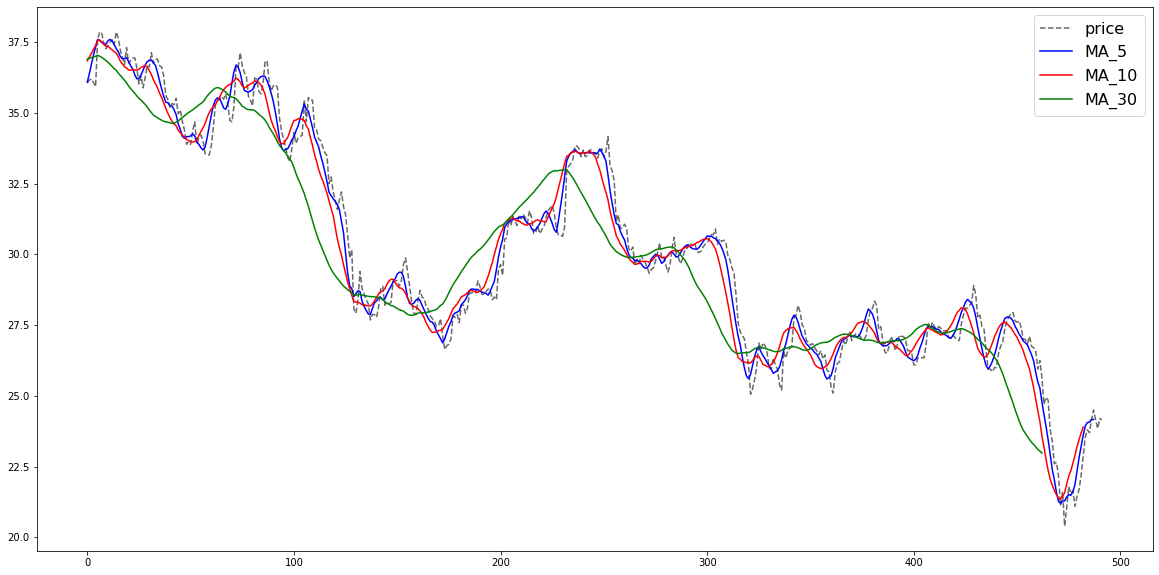

In [154]:
portfolio = ['2388.HK'] 
px = np.round(get_price(portfolio,2),4)
ma_px_5 = n_days_moving_avg(px,5)
ma_px_10 = n_days_moving_avg(px,10)
ma_px_30 = n_days_moving_avg(px,30)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(px, '--',color='dimgray', label="price",)
plt.plot(ma_px_5, color='blue', label="MA_5")
plt.plot(ma_px_10, color='red', label="MA_10")
plt.plot(ma_px_30, color='green', label="MA_30")
plt.legend(loc="upper right",fontsize=16)

**Find out turning points by 1st and 2nd difference**<br>
When the sign of 1st difference changes, it indicates an turning point. When the 2nd difference less than zero, it indicates a maximum point. <br>
However, some turning points are still very close after applying moving average.<br>
For example, at time t = 8, price = 37.352 while the next turing point is 37.357.

In [160]:
# use 10 days moving average
ma_px = ma_px_10

sec_diff = np.diff(np.sign(np.diff(ma_px)))

# find out turning points
turn_pt = []
for i in range(len(sec_diff)):
    if sec_diff[i]<0:
        turn_pt.append([i, ma_px[1:-1][i]])
    elif sec_diff[i]>0:
        turn_pt.append([i, ma_px[1:-1][i]])

np.round(turn_pt[:10],3)

array([[ 5.   , 37.578],
       [ 8.   , 37.352],
       [ 9.   , 37.357],
       [20.   , 36.506],
       [21.   , 36.533],
       [23.   , 36.51 ],
       [27.   , 36.68 ],
       [50.   , 33.974],
       [71.   , 36.227],
       [75.   , 35.884]])

**Eliminate insignifcant turning points**<br>
After applying a threshold of 2% change, the turning points are now more 'meaningful'.

In [159]:
# filter significant points using threshold=2%
turn_pt = [turn_pt[i] for i in range(len(turn_pt)-1) if abs(turn_pt[i+1][1]/turn_pt[i][1] - 1) > 0.02]

np.round(turn_pt[:10],3)

array([[  9.   ,  37.357],
       [ 27.   ,  36.68 ],
       [ 50.   ,  33.974],
       [ 80.   ,  36.133],
       [ 94.   ,  33.905],
       [101.   ,  34.793],
       [135.   ,  28.18 ],
       [147.   ,  29.123],
       [166.   ,  27.241],
       [188.   ,  28.661]])

**Output for Regression**<br>
The following code generates

**Dependent variable $r_i$** <br>
r = return of a given period

**Independent variables $\beta_{i,m}$** <br>
num_up = Number of travel from trough to peak<br>
num_down = Number of travel from peak to trough<br>
speed_up = Average ascent speed<br>
speed_down = Average descent speed<br>

In [161]:
# calculate speed
turn_pt = np.array(turn_pt).transpose()
dist = np.diff(turn_pt[1])
time = np.diff(turn_pt[0])
speed = dist/time

r = px[-1]/px[0] - 1

num_up = len([i for i in speed if i > 0])

num_down = len([i for i in speed if i < 0])

speed_up = sum([i for i in dist if i > 0]) / sum([time[i] for i in range(len(dist)) if dist[i] > 0])

speed_down = sum([i for i in dist if i < 0]) / sum([time[i] for i in range(len(dist)) if dist[i] < 0])

r, num_up, num_down, speed_up, speed_down

(-0.3304406892440773, 26, 29, 0.09280175609756092, -0.13826219607843132)

**What's Next**<br>
This notebook demostrated how to find the factor exposure for a single stock.<br>
In the next one, we need to gather data for more stocks (ie. 100 stocks in a single market), in order to study the relationship between return and this new factor(s).